<a href="https://colab.research.google.com/github/tirthankar369/Coursera_Capstone/blob/main/battle_of_neighbourhood.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np # library to handle data in a vectorized manner
import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

!pip install geopy # uncomment this line if you need to isntall geopy
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!pip install folium # uncomment this line if you need to install folium
import folium # map rendering library

import urllib.parse, urllib.error # library to handle url parsing for webscraping
from urllib.request import urlopen

!pip install beautifulsoup4 # uncomment this line if you need to install beautifulsoup
from bs4 import BeautifulSoup

!pip install WordCloud
from wordcloud import WordCloud, STOPWORDS 

print('Libraries imported.')

Libraries imported.


In [ ]:
data = [] # empty list for storing information

# Request a local copy of the Article
url = 'https://en.wikipedia.org/wiki/List_of_neighbourhoods_in_Mumbai'
html = urlopen(url) 
soup = BeautifulSoup(html, 'html.parser')

tables = soup.find_all('table')

#Create array to hold the data we extract
area = []
location = []
latitude = []
longitude = []

# Only 1st table contains data, we desire for this project
rows = tables[0].find_all('tr')

for row in rows:
    cells = row.find_all('td')
    if len(cells) > 1:
        area.append(cells[0].text.strip())
        location.append(cells[1].text.strip())
        latitude.append(cells[2].text.strip())
        longitude.append(cells[3].text.strip())

In [ ]:
# Creating a desired dataframe
data = np.array([area, location, latitude, longitude])
# The dataframe will consist of four columns: 'Area', 'Location', 'Latitude', 'Longitude'
column_values = ['Area', 'Location', 'Latitude', 'Longitude']
mum_neigh = pd.DataFrame(data = data.T, columns = column_values)
mum_neigh['Latitude'] = mum_neigh['Latitude'].astype(float)
mum_neigh['Longitude'] = mum_neigh['Longitude'].astype(float)

mum_neigh.head()

,Area,Location,Latitude,Longitude
0,Amboli,"Andheri,Western Suburbs",19.129300,72.843400
1,"Chakala, Andheri",Western Suburbs,19.111388,72.860833
2,D.N. Nagar,"Andheri,Western Suburbs",19.124085,72.831373
3,Four Bungalows,"Andheri,Western Suburbs",19.124714,72.827210
4,Lokhandwala,"Andheri,Western Suburbs",19.130815,72.829270


In [ ]:
address = 'Mumbai, Mahārāshtra, India'

geolocator = Nominatim(user_agent="pelican")
location = geolocator.geocode(address)
mum_lat = location.latitude
mum_lng = location.longitude

print('The geograpical coordinates of Mumbai are {}, {}.'.format(mum_lat, mum_lng))

The geograpical coordinates of Mumbai are 19.0759899, 72.8773928.


In [ ]:
# create map of Mumbai using latitude and longitude values
map_mum = folium.Map(location=[mum_lat, mum_lng], zoom_start=10)

# add markers to map
for lat, lng, ar, loc in zip(mum_neigh['Latitude'], mum_neigh['Longitude'], mum_neigh['Area'], mum_neigh['Location']):
    label = '{}, {}'.format(ar, loc)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=3,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_mum)  
    
map_mum

In [ ]:
# The code was removed by Vikash Kumar for sharing.
CLIENT_ID = 'GGVVYI54OJR5J4HJMMX0P5TT4JOYFOIJI00N1EVGDJG4SQKG' # your Foursquare ID
CLIENT_SECRET = 'XNRFBK4RBQCCBNCZGQKS4NBT2QIR4GRHU0VPBY2STBDTUOIJ' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: GGVVYI54OJR5J4HJMMX0P5TT4JOYFOIJI00N1EVGDJG4SQKG
CLIENT_SECRET:XNRFBK4RBQCCBNCZGQKS4NBT2QIR4GRHU0VPBY2STBDTUOIJ


In [ ]:
neigh_num = 21 # For Juhu in the dataframe
neighborhood_latitude = mum_neigh.loc[neigh_num, 'Latitude'] # neighborhood latitude value
neighborhood_longitude = mum_neigh.loc[neigh_num, 'Longitude'] # neighborhood longitude value

neighborhood_name = '{}, {}'.format(mum_neigh.loc[neigh_num, 'Area'], mum_neigh.loc[neigh_num, 'Location']) # neighborhood name

print('Latitude and longitude values of {} are {}, {}.'.format(neighborhood_name, 
                                                               neighborhood_latitude, 
                                                               neighborhood_longitude))

Latitude and longitude values of Juhu, Western Suburbs are 19.1, 72.83.


In [ ]:
radius = 1000
LIMIT = 100

# create URL
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    neighborhood_latitude, 
    neighborhood_longitude, 
    radius, 
    LIMIT)

results = requests.get(url).json()

In [ ]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [ ]:
venues = results['response']['groups'][0]['items']
    
nearby_venues = pd.json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head()

,name,categories,lat,lng
0,Starbucks,Coffee Shop,19.100479,72.827438
1,JW Marriott Mumbai Juhu,Hotel,19.102037,72.826181
2,JW Marriot executive lounge,Lounge,19.101686,72.825897
3,Soho House,Club House,19.095805,72.829070
4,Smooch Italian Frozen Yogurt,Dessert Shop,19.096430,72.827640


In [ ]:
print('{} venues were returned by Foursquare.'.format(nearby_venues.shape[0]))

71 venues were returned by Foursquare.


In [ ]:
radius = 1000
LIMIT = 100
catId = '4d4b7105d754a06374d81259' # Category ID for 'Food.' This will return all sub-categories'

# create URL
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&categoryId={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    neighborhood_latitude, 
    neighborhood_longitude, 
    radius,
    catId, # add the category ID to the URL
    LIMIT)

results = requests.get(url).json()

venues = results['response']['groups'][0]['items']
    
nearby_venues = pd.json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]
# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head()

,name,categories,lat,lng
0,Lotus Café,Indian Restaurant,19.101772,72.825664
1,Mahesh Lunch Home,Seafood Restaurant,19.103680,72.826794
2,Arola @ JW Marriott,Spanish Restaurant,19.101647,72.825477
3,Gajalee,Seafood Restaurant,19.103827,72.831028
4,Bombay Baking Company,Bakery,19.101836,72.825922


In [ ]:
print('{} venues were returned by Foursquare.'.format(nearby_venues.shape[0]))

59 venues were returned by Foursquare.


In [ ]:
def getNearbyVenues(areas, locations, latitudes, longitudes, catId, radius=1000):
    
    venues_list=[]
    for ar, loc, lat, lng in zip(areas, locations, latitudes, longitudes):
        name = ar + ', ' + loc
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&categoryId={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius,
            catId,
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                             'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [ ]:
mum_rests = getNearbyVenues(areas=mum_neigh['Area'],
                                locations=mum_neigh['Location'],
                                latitudes=mum_neigh['Latitude'],
                                longitudes=mum_neigh['Longitude'],
                                catId='4d4b7105d754a06374d81259')
print(mum_rests.shape)
mum_rests.head()

Amboli, Andheri,Western Suburbs
Chakala, Andheri, Western Suburbs
D.N. Nagar, Andheri,Western Suburbs
Four Bungalows, Andheri,Western Suburbs
Lokhandwala, Andheri,Western Suburbs
Marol, Andheri,Western Suburbs
Sahar, Andheri,Western Suburbs
Seven Bungalows, Andheri,Western Suburbs
Versova, Andheri,Western Suburbs
Mira Road, Mira-Bhayandar,Western Suburbs
Bhayandar, Mira-Bhayandar,Western Suburbs
Uttan, Mira-Bhayandar,Western Suburbs
Bandstand Promenade, Bandra,Western Suburbs
Kherwadi, Bandra,Western Suburbs
Pali Hill, Bandra,Western Suburbs
I.C. Colony, Borivali (West),Western Suburbs
Gorai, Borivali (West),Western Suburbs
Dahisar, Western Suburbs
Aarey Milk Colony, Goregaon,Western Suburbs
Bangur Nagar, Goregaon,Western Suburbs
Jogeshwari West, Western Suburbs
Juhu, Western Suburbs
Charkop, Kandivali West,Western Suburbs
Poisar, Kandivali West,Western Suburbs
Mahavir Nagar, Kandivali West,Western Suburbs
Thakur village, Kandivali East,Western Suburbs
Pali Naka, Khar,Western Suburbs
K

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"Amboli, Andheri,Western Suburbs",19.1293,72.8434,Shawarma Factory,19.124591,72.840398,Falafel Restaurant
1,"Amboli, Andheri,Western Suburbs",19.1293,72.8434,Cafe Arfa,19.128930,72.847140,Indian Restaurant
2,"Amboli, Andheri,Western Suburbs",19.1293,72.8434,Jaffer Bhai's Delhi Darbar,19.137714,72.845909,Mughlai Restaurant
3,"Amboli, Andheri,Western Suburbs",19.1293,72.8434,"5 Spice , Bandra",19.130421,72.847206,Chinese Restaurant
4,"Amboli, Andheri,Western Suburbs",19.1293,72.8434,Pizza Express,19.131893,72.834668,Pizza Place


In [ ]:
mum_rests[['Neighborhood', 'Venue']].groupby('Neighborhood').count().reset_index().head()

,Neighborhood,Venue
0,"Aarey Milk Colony, Goregaon,Western Suburbs",5
1,"Agripada, South Mumbai",23
2,"Altamount Road, South Mumbai",69
3,"Amboli, Andheri,Western Suburbs",27
4,"Amrut Nagar, Ghatkopar,Eastern Suburbs",39


In [ ]:
print('There are {} unique types of restaurants in Mumbai.'.format(len(mum_rests['Venue Category'].unique())))

There are 76 unique types of restaurants in Mumbai.


In [ ]:
mum_rests[['Venue Category', 'Venue']].groupby('Venue Category').count().sort_values(by=['Venue'], ascending=False).reset_index().head()

,Venue Category,Venue
0,Indian Restaurant,729
1,Café,279
2,Fast Food Restaurant,250
3,Bakery,193
4,Chinese Restaurant,188


In [ ]:
# one hot encoding
mum_onehot = pd.get_dummies(mum_rests[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
mum_onehot['Neighborhood'] = mum_rests['Neighborhood']

# move neighborhood column to the first column
first_col = ['Neighborhood']
fixed_columns = [col for col in mum_onehot if col not in first_col]
mum_onehot = mum_onehot[first_col + fixed_columns]

mum_onehot.head()

,Neighborhood,Afghan Restaurant,American Restaurant,Asian Restaurant,BBQ Joint,Bagel Shop,Bakery,Bengali Restaurant,Bistro,Breakfast Spot,Buffet,Burger Joint,Burrito Place,Cafeteria,Café,Chaat Place,Chinese Restaurant,Comfort Food Restaurant,Creperie,Deli / Bodega,Dhaba,Dim Sum Restaurant,Diner,Donut Shop,Dumpling Restaurant,English Restaurant,Falafel Restaurant,Fast Food Restaurant,Fish & Chips Shop,Food,Food Court,Food Truck,French Restaurant,Fried Chicken Joint,Gastropub,German Restaurant,Gluten-free Restaurant,Goan Restaurant,Greek Restaurant,Halal Restaurant,Hot Dog Joint,Indian Chinese Restaurant,Indian Restaurant,Indian Sweet Shop,Irani Cafe,Irish Pub,Italian Restaurant,Japanese Restaurant,Korean Restaurant,Maharashtrian Restaurant,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Modern European Restaurant,Molecular Gastronomy Restaurant,Mughlai Restaurant,Multicuisine Indian Restaurant,New American Restaurant,Noodle House,North Indian Restaurant,Parsi Restaurant,Pizza Place,Portuguese Restaurant,Punjabi Restaurant,Restaurant,Salad Place,Sandwich Place,Seafood Restaurant,Shawarma Place,Snack Place,South Indian Restaurant,Spanish Restaurant,Steakhouse,Sushi Restaurant,Tex-Mex Restaurant,Thai Restaurant,Vegetarian / Vegan Restaurant
0,"Amboli, Andheri,Western Suburbs",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,"Amboli, Andheri,Western Suburbs",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,"Amboli, Andheri,Western Suburbs",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,"Amboli, Andheri,Western Suburbs",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,"Amboli, Andheri,Western Suburbs",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
mum_groups = mum_onehot.groupby('Neighborhood').mean().reset_index()
mum_groups.head()

,Neighborhood,Afghan Restaurant,American Restaurant,Asian Restaurant,BBQ Joint,Bagel Shop,Bakery,Bengali Restaurant,Bistro,Breakfast Spot,Buffet,Burger Joint,Burrito Place,Cafeteria,Café,Chaat Place,Chinese Restaurant,Comfort Food Restaurant,Creperie,Deli / Bodega,Dhaba,Dim Sum Restaurant,Diner,Donut Shop,Dumpling Restaurant,English Restaurant,Falafel Restaurant,Fast Food Restaurant,Fish & Chips Shop,Food,Food Court,Food Truck,French Restaurant,Fried Chicken Joint,Gastropub,German Restaurant,Gluten-free Restaurant,Goan Restaurant,Greek Restaurant,Halal Restaurant,Hot Dog Joint,Indian Chinese Restaurant,Indian Restaurant,Indian Sweet Shop,Irani Cafe,Irish Pub,Italian Restaurant,Japanese Restaurant,Korean Restaurant,Maharashtrian Restaurant,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Modern European Restaurant,Molecular Gastronomy Restaurant,Mughlai Restaurant,Multicuisine Indian Restaurant,New American Restaurant,Noodle House,North Indian Restaurant,Parsi Restaurant,Pizza Place,Portuguese Restaurant,Punjabi Restaurant,Restaurant,Salad Place,Sandwich Place,Seafood Restaurant,Shawarma Place,Snack Place,South Indian Restaurant,Spanish Restaurant,Steakhouse,Sushi Restaurant,Tex-Mex Restaurant,Thai Restaurant,Vegetarian / Vegan Restaurant
0,"Aarey Milk Colony, Goregaon,Western Suburbs",0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.200000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.200000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.400000,0.000000,0.000000,0.0,0.0,0.200000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000
1,"Agripada, South Mumbai",0.000000,0.000000,0.043478,0.000000,0.0,0.173913,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.130435,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.086957,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.304348,0.0,0.0,0.0,0.000000,0.043478,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.043478,0.0,0.000000,0.173913,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000
2,"Altamount Road, South Mumbai",0.000000,0.000000,0.000000,0.000000,0.0,0.115942,0.014493,0.0,0.014493,0.0,0.000000,0.0,0.014493,0.101449,0.0,0.086957,0.0,0.0,0.028986,0.0,0.0,0.014493,0.014493,0.0,0.0,0.014493,0.072464,0.0,0.0,0.028986,0.028986,0.014493,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.130435,0.0,0.0,0.0,0.043478,0.014493,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.043478,0.0,0.000000,0.072464,0.014493,0.057971,0.0,0.0,0.028986,0.0,0.0,0.000000,0.0,0.0,0.0,0.028986
3,"Amboli, Andheri,Western Suburbs",0.000000,0.000000,0.111111,0.037037,0.0,0.037037,0.000000,0.0,0.000000,0.0,0.037037,0.0,0.000000,0.000000,0.0,0.074074,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.037037,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.037037,0.000000,0.0,0.296296,0.0,0.0,0.0,0.037037,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.074074,0.0,0.0,0.0,0.0,0.0,0.111111,0.0,0.000000,0.000000,0.000000,0.037037,0.0,0.0,0.037037,0.0,0.0,0.000000,0.0,0.0,0.0,0.037037
4,"Amrut Nagar, Ghatkopar,Eastern Suburbs",0.025641,0.025641,0.051282,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.025641,0.179487,0.0,0.051282,0.0,0.0,0.000000,0.0,0.0,0.051282,0.000000,0.0,0.0,0.025641,0.076923,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.025641,0.0,0.0,0.0,0.0,0.000000,0.025641,0.0,0.153846,0.0,0.0,0.0,0.025641,0.000000,0.0,0.0,0.025641,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.076923,0.0,0.025641,0.025641,0.000000,0.025641,0.0,0.0,0.000000,0.0,0.0,0.025641,0.0,0.0,0.0,0.051282


In [ ]:
# function to find and return most x most top venues
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [ ]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = mum_groups['Neighborhood']

for ind in np.arange(mum_groups.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(mum_groups.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"Aarey Milk Colony, Goregaon,Western Suburbs",Restaurant,Indian Restaurant,Café,Snack Place,Vegetarian / Vegan Restaurant,Dim Sum Restaurant,Diner,Donut Shop,Dumpling Restaurant,English Restaurant
1,"Agripada, South Mumbai",Indian Restaurant,Bakery,Restaurant,Chinese Restaurant,Fast Food Restaurant,Asian Restaurant,Pizza Place,Japanese Restaurant,Vegetarian / Vegan Restaurant,Donut Shop
2,"Altamount Road, South Mumbai",Indian Restaurant,Bakery,Café,Chinese Restaurant,Restaurant,Fast Food Restaurant,Sandwich Place,Italian Restaurant,Pizza Place,Food Truck
3,"Amboli, Andheri,Western Suburbs",Indian Restaurant,Asian Restaurant,Pizza Place,Mughlai Restaurant,Chinese Restaurant,Sandwich Place,Italian Restaurant,Falafel Restaurant,Burger Joint,Vegetarian / Vegan Restaurant
4,"Amrut Nagar, Ghatkopar,Eastern Suburbs",Café,Indian Restaurant,Pizza Place,Fast Food Restaurant,Vegetarian / Vegan Restaurant,Asian Restaurant,Chinese Restaurant,Diner,American Restaurant,Cafeteria


In [ ]:
mum_clustering = mum_groups.drop('Neighborhood', 1)


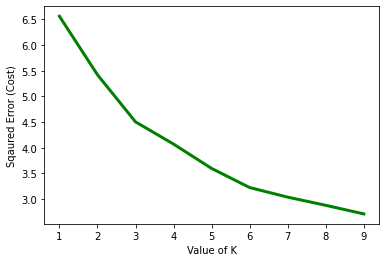

In [ ]:
import matplotlib.pyplot as plt  
from matplotlib import style 

cost =[] 
max_clust = 10
for i in range(1, max_clust): 
    KM = KMeans(n_clusters = i, max_iter = 500) 
    KM.fit(mum_clustering) 
      
    # calculates squared error 
    # for the clustered points 
    cost.append(KM.inertia_)      
  
# plot the cost against K values 
plt.plot(range(1, max_clust), cost, color ='g', linewidth ='3') 
plt.xlabel("Value of K") 
plt.ylabel("Sqaured Error (Cost)") 
plt.show() # clear the plot

In [ ]:
kclusters = 5

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(mum_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[1:10]

array([0, 2, 0, 2, 0, 0, 3, 3, 0], dtype=int32)

In [ ]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

mum_merge = mum_neigh
mum_merge['Neighborhood'] = mum_neigh['Area'] + ', ' + mum_neigh['Location']

# merge mum_grouped with mum_data to add latitude/longitude for each neighborhood
mum_merge = mum_merge.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

mum_merge.head() # check the last columns!

,Area,Location,Latitude,Longitude,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Amboli,"Andheri,Western Suburbs",19.129300,72.843400,"Amboli, Andheri,Western Suburbs",0.0,Indian Restaurant,Asian Restaurant,Pizza Place,Mughlai Restaurant,Chinese Restaurant,Sandwich Place,Italian Restaurant,Falafel Restaurant,Burger Joint,Vegetarian / Vegan Restaurant
1,"Chakala, Andheri",Western Suburbs,19.111388,72.860833,"Chakala, Andheri, Western Suburbs",2.0,Indian Restaurant,Restaurant,Café,Seafood Restaurant,Pizza Place,Vegetarian / Vegan Restaurant,Fast Food Restaurant,Chinese Restaurant,Bakery,Punjabi Restaurant
2,D.N. Nagar,"Andheri,Western Suburbs",19.124085,72.831373,"D.N. Nagar, Andheri,Western Suburbs",2.0,Indian Restaurant,Pizza Place,Vegetarian / Vegan Restaurant,Snack Place,Chinese Restaurant,Asian Restaurant,Burger Joint,Bakery,Japanese Restaurant,Falafel Restaurant
3,Four Bungalows,"Andheri,Western Suburbs",19.124714,72.827210,"Four Bungalows, Andheri,Western Suburbs",2.0,Indian Restaurant,Vegetarian / Vegan Restaurant,Restaurant,Chinese Restaurant,Café,Pizza Place,Asian Restaurant,Japanese Restaurant,Snack Place,Shawarma Place
4,Lokhandwala,"Andheri,Western Suburbs",19.130815,72.829270,"Lokhandwala, Andheri,Western Suburbs",2.0,Indian Restaurant,Pizza Place,Asian Restaurant,Vegetarian / Vegan Restaurant,Sandwich Place,Diner,Italian Restaurant,Café,Mediterranean Restaurant,Restaurant


In [ ]:
mum_merge['Cluster Labels'] = mum_merge['Cluster Labels'].fillna(0)
mum_merge['Cluster Labels'] = mum_merge['Cluster Labels'].astype(int)

# create map
map_clusters = folium.Map(location=[mum_lat, mum_lng], zoom_start=10)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(mum_merge['Latitude'], mum_merge['Longitude'], mum_merge['Neighborhood'], mum_merge['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=3,
        popup=label,
        color=rainbow[cluster],
        fill=True,
        fill_color=rainbow[cluster],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [ ]:
mum_merge.loc[(mum_merge['Cluster Labels'] == 0) & 
              (mum_merge['1st Most Common Venue'].notnull()), 
              mum_merge.columns[range(4,11)]]

,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,"Amboli, Andheri,Western Suburbs",0,Indian Restaurant,Asian Restaurant,Pizza Place,Mughlai Restaurant,Chinese Restaurant
16,"Gorai, Borivali (West),Western Suburbs",0,Food,Indian Restaurant,Seafood Restaurant,Fish & Chips Shop,Dim Sum Restaurant
20,"Jogeshwari West, Western Suburbs",0,Indian Restaurant,Fast Food Restaurant,Vegetarian / Vegan Restaurant,Food Truck,Chinese Restaurant
34,"Irla, Vile Parle,Western Suburbs",0,Indian Restaurant,Fast Food Restaurant,Café,Food Truck,Snack Place
36,"Bhandup, Eastern Suburbs",0,Indian Restaurant,Fast Food Restaurant,Vegetarian / Vegan Restaurant,Asian Restaurant,Fried Chicken Joint
38,"Asalfa, Ghatkopar,Eastern Suburbs",0,Indian Restaurant,Bakery,Vegetarian / Vegan Restaurant,Donut Shop,Snack Place
39,"Pant Nagar, Ghatkopar,Eastern Suburbs",0,Indian Restaurant,Fast Food Restaurant,Restaurant,Sandwich Place,Café
44,"Hiranandani Gardens, Powai,Eastern Suburbs",0,Indian Restaurant,Restaurant,Café,Pizza Place,Fast Food Restaurant
45,"Indian Institute of Technology Bombay campus, ...",0,Indian Restaurant,Bakery,Food Court,Café,Food
49,"Deonar, Govandi,Harbour Suburbs",0,Indian Restaurant,Fast Food Restaurant,Chinese Restaurant,Restaurant,Food Truck


In [ ]:
mum_merge.loc[(mum_merge['Cluster Labels'] == 1) & 
              (mum_merge['1st Most Common Venue'].notnull()), 
              mum_merge.columns[range(4,11)]]

,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
31,"Naigaon, Vasai,Western Suburbs",1,Chinese Restaurant,Vegetarian / Vegan Restaurant,Fish & Chips Shop,Diner,Donut Shop


In [ ]:
mum_merge.loc[(mum_merge['Cluster Labels'] == 2) & 
              (mum_merge['1st Most Common Venue'].notnull()), 
              mum_merge.columns[range(4,11)]]

,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
1,"Chakala, Andheri, Western Suburbs",2,Indian Restaurant,Restaurant,Café,Seafood Restaurant,Pizza Place
2,"D.N. Nagar, Andheri,Western Suburbs",2,Indian Restaurant,Pizza Place,Vegetarian / Vegan Restaurant,Snack Place,Chinese Restaurant
3,"Four Bungalows, Andheri,Western Suburbs",2,Indian Restaurant,Vegetarian / Vegan Restaurant,Restaurant,Chinese Restaurant,Café
4,"Lokhandwala, Andheri,Western Suburbs",2,Indian Restaurant,Pizza Place,Asian Restaurant,Vegetarian / Vegan Restaurant,Sandwich Place
6,"Sahar, Andheri,Western Suburbs",2,Fast Food Restaurant,Indian Restaurant,Café,Italian Restaurant,Asian Restaurant
7,"Seven Bungalows, Andheri,Western Suburbs",2,Café,Indian Restaurant,Chinese Restaurant,Pizza Place,Vegetarian / Vegan Restaurant
8,"Versova, Andheri,Western Suburbs",2,Indian Restaurant,Café,Diner,Chinese Restaurant,Bakery
9,"Mira Road, Mira-Bhayandar,Western Suburbs",2,Indian Restaurant,Pizza Place,Chinese Restaurant,Café,Fast Food Restaurant
13,"Kherwadi, Bandra,Western Suburbs",2,Café,Indian Restaurant,Chinese Restaurant,Bakery,Snack Place
14,"Pali Hill, Bandra,Western Suburbs",2,Indian Restaurant,Asian Restaurant,Café,Bakery,Fast Food Restaurant


In [ ]:
mum_merge.loc[(mum_merge['Cluster Labels'] == 3) & 
              (mum_merge['1st Most Common Venue'].notnull()), 
              mum_merge.columns[range(4,11)]]

,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
10,"Bhayandar, Mira-Bhayandar,Western Suburbs",3,Indian Restaurant,Fast Food Restaurant,Vegetarian / Vegan Restaurant,Mexican Restaurant,Pizza Place
12,"Bandstand Promenade, Bandra,Western Suburbs",3,Food Truck,Fast Food Restaurant,Chinese Restaurant,Indian Restaurant,Pizza Place
15,"I.C. Colony, Borivali (West),Western Suburbs",3,Indian Restaurant,Bakery,Fast Food Restaurant,Chinese Restaurant,Pizza Place
19,"Bangur Nagar, Goregaon,Western Suburbs",3,Indian Restaurant,Fast Food Restaurant,Bakery,Food Truck,Food Court
22,"Charkop, Kandivali West,Western Suburbs",3,Indian Restaurant,Fast Food Restaurant,Chinese Restaurant,Bakery,Fish & Chips Shop
23,"Poisar, Kandivali West,Western Suburbs",3,Food Truck,Bakery,Fast Food Restaurant,Pizza Place,Chinese Restaurant
24,"Mahavir Nagar, Kandivali West,Western Suburbs",3,Fast Food Restaurant,Indian Restaurant,Bakery,Food,Chinese Restaurant
28,"Dindoshi, Malad,Western Suburbs",3,Indian Restaurant,Fast Food Restaurant,Vegetarian / Vegan Restaurant,Chinese Restaurant,Bakery
33,"Virar, Western Suburbs",3,Fast Food Restaurant,Indian Chinese Restaurant,Indian Restaurant,Bakery,Pizza Place
46,"Vidyavihar, Eastern Suburbs",3,Fast Food Restaurant,Indian Restaurant,Chinese Restaurant,Sandwich Place,Restaurant


In [ ]:
mum_merge.loc[(mum_merge['Cluster Labels'] == 4) & 
              (mum_merge['1st Most Common Venue'].notnull()), 
              mum_merge.columns[range(4,11)]]

,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
5,"Marol, Andheri,Western Suburbs",4,Indian Restaurant,Restaurant,Food,Diner,Chinese Restaurant
11,"Uttan, Mira-Bhayandar,Western Suburbs",4,Indian Restaurant,Vegetarian / Vegan Restaurant,Fish & Chips Shop,Dim Sum Restaurant,Diner
32,"Nalasopara, Vasai,Western Suburbs",4,Indian Restaurant,Seafood Restaurant,Vegetarian / Vegan Restaurant,Fish & Chips Shop,Dim Sum Restaurant
42,"Nahur, Mulund,Eastern Suburbs",4,Indian Restaurant,Café,Restaurant,Vegetarian / Vegan Restaurant,Fast Food Restaurant
64,"Dongri, South Mumbai",4,Indian Restaurant,Chinese Restaurant,Vegetarian / Vegan Restaurant,Fish & Chips Shop,Diner


In [ ]:
labels = ['Indian Cousin', 'Bad Choice', 'Multi-Cousin', 'Indian Continental', 'Seafood']

# create map
map_clusters = folium.Map(location=[mum_lat, mum_lng], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(mum_merge['Latitude'], mum_merge['Longitude'], mum_merge['Neighborhood'], mum_merge['Cluster Labels']):
    label = folium.Popup(str(poi)+' '+labels[cluster], parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=3,
        popup=label,
        color=rainbow[cluster],
        fill=True,
        fill_color=rainbow[cluster],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [ ]:
mum_counts = mum_rests.groupby('Neighborhood').count()
mum_counts.head()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
"Aarey Milk Colony, Goregaon,Western Suburbs",5,5,5,5,5,5
"Agripada, South Mumbai",23,23,23,23,23,23
"Altamount Road, South Mumbai",69,69,69,69,69,69
"Amboli, Andheri,Western Suburbs",27,27,27,27,27,27
"Amrut Nagar, Ghatkopar,Eastern Suburbs",39,39,39,39,39,39


In [ ]:
labels = ['Indian Cousin', 'Bad Choice', 'Multi-Cousin', 'Indian Continental', 'Seafood']

# create map
map_clusters = folium.Map(location=[mum_lat, mum_lng], zoom_start=14)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(mum_merge['Latitude'], mum_merge['Longitude'], mum_merge['Neighborhood'], mum_merge['Cluster Labels']):
    label = folium.Popup(str(poi)+' '+labels[cluster], parse_html=True)
    try:
        size = int(mum_counts.loc[poi,'Venue'])
    except:
        size = 0
    folium.CircleMarker(
        [lat, lon],
        radius=3+size,
        popup=label,
        color=rainbow[cluster],
        fill=True,
        fill_color=rainbow[cluster],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [ ]:
neigh_id = mum_neigh[mum_neigh['Neighborhood'] == 'Nariman Point, South Mumbai'].index[0]

neighborhood_latitude = mum_neigh.loc[neigh_id, 'Latitude'] # neighborhood latitude value
neighborhood_longitude = mum_neigh.loc[neigh_id, 'Longitude'] # neighborhood longitude value

neighborhood_name = mum_neigh.loc[neigh_id, 'Neighborhood'] # neighborhood name

print('Latitude and longitude values of {} are {}, {}.'.format(neighborhood_name, 
                                                               neighborhood_latitude, 
                                                               neighborhood_longitude))

Latitude and longitude values of Nariman Point, South Mumbai are 18.926, 72.823.


In [ ]:
radius = 1500
LIMIT = 100
catId = '4d4b7105d754a06374d81259' # Category ID for 'Food.' This will return all sub-categories'

# create URL
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&categoryId={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    neighborhood_latitude, 
    neighborhood_longitude, 
    radius,
    catId, # add the category ID to the URL
    LIMIT)

results = requests.get(url).json()

venues = results['response']['groups'][0]['items']
    
nearby_venues = pd.json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]
nearby_venues

,name,categories,lat,lng
0,The Sassy Spoon,Diner,18.928426,72.822512
1,Status,Indian Restaurant,18.924562,72.821526
2,Swati Snacks,Chaat Place,18.924436,72.824756
3,Café at the NCPA,Café,18.925257,72.819578
4,India Jones,Restaurant,18.927878,72.820664
5,The J,Fast Food Restaurant,18.930374,72.826734
6,Fenix Oberoi,Restaurant,18.927144,72.820143
7,The Bayview - Hotel Marine Plaza,Italian Restaurant,18.931876,72.823031
8,Frangipani,Mediterranean Restaurant,18.927910,72.820679
9,"The Oriental Blossom, Marine Plaza",Asian Restaurant,18.931605,72.823121


In [ ]:
# Sort the data by frequency
sorted_venues = nearby_venues.groupby(['categories']).size().reset_index(name='Count')
sorted_venues.columns=['Restaurant Type','Count']
sorted_venues.set_index('Restaurant Type')

,Count
Restaurant Type,
Asian Restaurant,3
Bakery,3
Breakfast Spot,2
Café,13
Chaat Place,2
Chinese Restaurant,5
Deli / Bodega,1
Diner,5
Donut Shop,2


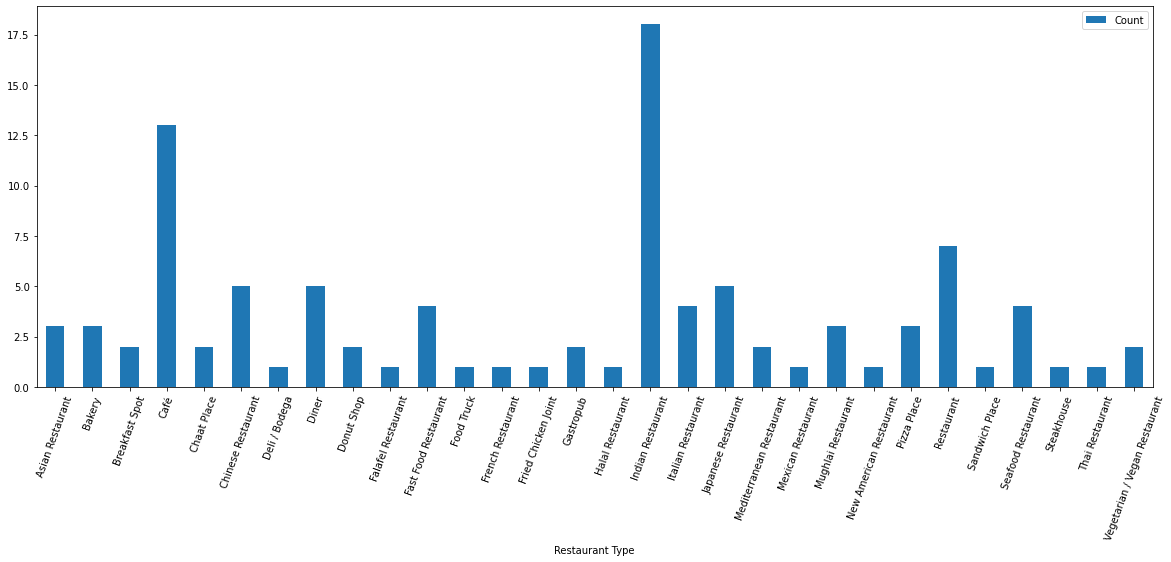

In [ ]:
sorted_venues.plot(x='Restaurant Type', y='Count', kind='bar', figsize=(20,7), rot=70)

plt.show()

In [ ]:
def getCoords(neigh):
    try:
        neigh_id = nola_neigh[nola_neigh['Neighborhood']==neigh].index[0]

        neighborhood_latitude = nola_neigh.loc[neigh_id, 'Latitude'] # neighborhood latitude value
        neighborhood_longitude = nola_neigh.loc[neigh_id, 'Longitude'] # neighborhood longitude value

        neighborhood_name = nola_neigh.loc[neigh_id, 'Neighborhood'] # neighborhood name
        
        return [neighborhood_name,neighborhood_latitude,neighborhood_longitude]
    except:
        return print('Neighborhood name not recognized. Please try again.')

In [ ]:
def getVenues(lat,lng,catId,radius=1500):
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&categoryId={}&limit={}'.format(
        CLIENT_ID, 
        CLIENT_SECRET, 
        VERSION, 
        lat, 
        lng, 
        radius,
        catId, # add the category ID to the URL
        LIMIT)

    results = requests.get(url).json()

    venues = results['response']['groups'][0]['items']
    
    nearby_venues = pd.json_normalize(venues) # flatten JSON

    # filter columns
    filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
    nearby_venues =nearby_venues.loc[:, filtered_columns]

    # filter the category for each row
    nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

    # clean columns
    nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

    return(nearby_venues)

In [ ]:
def makeGraph(neigh):
    
    coords = getCoords(neigh)
    
    df = getVenues(coords[1],coords[2],'4d4b7105d754a06374d81259')
    
    sorted_venues = df.groupby(['categories']).size().reset_index(name='Count')
    sorted_venues.columns=['Restaurant Type','Count']
    sorted_venues.set_index('Restaurant Type')
    
    sorted_venues.plot(x='Restaurant Type', y='Count', kind='bar', figsize=(20,7), rot=70, title='Restaurants in {}'.format(neigh))

    return plt.show()

In [ ]:
neigh = 'Charkop Kandivali West,Western Suburbs'
makeGraph(neigh)

Neighborhood name not recognized. Please try again.


TypeError: ignored

In [ ]:

map_clusters

In [ ]:
neigh = 'Mahavir Nagar, Kandivali West,Western Suburbs'
makeGraph(neigh)

Neighborhood name not recognized. Please try again.


TypeError: ignored